In [87]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from statsmodels.stats.outliers_influence \
     import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)

In [14]:
fed_emp = pd.read_csv('federal_public_employment_raw_in_thousands.csv')
manufact_emp = pd.read_csv('manufacturing_employment_raw_in_thousands.csv')
private_emp = pd.read_csv('private_employment_raw_in_thousands.csv')
retail_emp = pd.read_csv('retail_trade_employment_raw_in_thousands.csv')
edu_emp = pd.read_csv('state_and_local_public_education_employment_raw_in_thousands.csv')
state_emp = pd.read_csv('state_and_local_public_employment_raw_in_thousands.csv')
tot_emp = pd.read_csv('total_employment_raw_in_thousands.csv')

In [27]:
# Extracting data for only years 2018-2023
ext_fed_emp = fed_emp[["Geography", "2018-01-01"] +
                                list(fed_emp.columns[fed_emp.columns.get_loc('2018-01-01')
                                                       +1:])]
ext_manufact_emp = manufact_emp[["Geography", "2018-01-01"] +
                                list(manufact_emp.columns[manufact_emp.columns.get_loc('2018-01-01')
                                                       +1:])]
ext_private_emp = private_emp[["Geography", "2018-01-01"] +
                                list(private_emp.columns[private_emp.columns.get_loc('2018-01-01')
                                                       +1:])]
ext_retail_emp = retail_emp[["Geography", "2018-01-01"] +
                                list(retail_emp.columns[retail_emp.columns.get_loc('2018-01-01')
                                                       +1:])]
ext_edu_emp = edu_emp[["Geography", "2018-01-01"] +
                                list(edu_emp.columns[edu_emp.columns.get_loc('2018-01-01')
                                                       +1:])]
ext_state_emp = state_emp[["Geography", "2018-01-01"] +
                                list(state_emp.columns[state_emp.columns.get_loc('2018-01-01')
                                                       +1:])]
ext_tot_emp = tot_emp[["Geography", "2018-01-01"] +
                                list(tot_emp.columns[tot_emp.columns.get_loc('2018-01-01')
                                                       +1:])]

ext_fed_emp = ext_fed_emp.iloc[[0]]
ext_manufact_emp = ext_manufact_emp.iloc[[0]]
ext_private_emp = ext_private_emp.iloc[[0]]
ext_retail_emp = ext_retail_emp.iloc[[0]]
ext_edu_emp = ext_edu_emp.iloc[[0]]
ext_state_emp = ext_state_emp.iloc[[0]]
ext_tot_emp = ext_tot_emp.iloc[[0]]

,Geography,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,...,2022-12-01,2023-01-01,2023-02-01,2023-03-01,2023-04-01,2023-05-01,2023-06-01,2023-07-01,2023-08-01,2023-09-01
0,United States,15709.2,15756.9,15772.4,15772.7,15788.1,15740.7,15725.0,15725.5,15686.2,...,15477.8,15500.1,15548.1,15529.2,15527.2,15548.1,15525.4,15538.0,15538.4,15558.1


In [52]:
merged_data = pd.concat([ext_fed_emp, 
                         ext_manufact_emp, 
                         ext_private_emp, 
                         ext_retail_emp, 
                         ext_edu_emp, 
                         ext_state_emp, 
                         ext_tot_emp], 
                         axis=0)


# Assign new row names to the DataFrame
merged_data.index = ['Federal',
                     'Manufacturing',
                     'Private', 
                     'Retail', 
                     'Education', 
                     'State & Local', 
                     'Total Employment']

merged_data = merged_data.drop(merged_data.columns[0], axis=1)
emp = merged_data.transpose()
emp

,Federal,Manufacturing,Private,Retail,Education,State & Local,Total Employment
2018-01-01,2794.0,12561.0,125296.0,15709.2,10416.8,19580.0,147670.0
2018-02-01,2790.0,12584.0,125639.0,15756.9,10875.7,19629.0,148058.0
2018-03-01,2792.0,12610.0,125854.0,15772.4,10920.9,19635.0,148281.0
2018-04-01,2800.0,12631.0,125982.0,15772.7,10903.1,19644.0,148426.0
2018-05-01,2793.0,12657.0,126306.0,15788.1,10755.9,19656.0,148755.0
...,...,...,...,...,...,...,...
2023-05-01,2919.0,12981.0,133341.0,15548.1,10720.3,19710.0,155970.0
2023-06-01,2925.0,12985.0,133427.0,15525.4,10121.8,19723.0,156075.0
2023-07-01,2935.0,12983.0,133572.0,15538.0,9039.0,19804.0,156311.0
2023-08-01,2946.0,12994.0,133749.0,15538.4,9474.7,19843.0,156538.0


In [61]:
X = pd.DataFrame({'intercept': np.ones(emp.shape[0]),
                  'fed': emp['Federal'],
                  'man': emp['Manufacturing'],
                  'priv': emp['Private'],
                  'retl': emp['Retail'],
                  'edu': emp['Education'],
                  'sl':emp['State & Local']})
X[:5]

,intercept,fed,man,priv,retl,edu,sl
2018-01-01,1.0,2794.0,12561.0,125296.0,15709.2,10416.8,19580.0
2018-02-01,1.0,2790.0,12584.0,125639.0,15756.9,10875.7,19629.0
2018-03-01,1.0,2792.0,12610.0,125854.0,15772.4,10920.9,19635.0
2018-04-01,1.0,2800.0,12631.0,125982.0,15772.7,10903.1,19644.0
2018-05-01,1.0,2793.0,12657.0,126306.0,15788.1,10755.9,19656.0


In [62]:
y = emp['Total Employment']
model = sm.OLS(y, X)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,-3.526000e-10,5.970000e-08,-6.000000e-03,0.995
fed,1.000000e+00,1.010000e-11,9.880000e+10,0.000
man,2.211000e-13,8.650000e-12,2.600000e-02,0.980
priv,1.000000e+00,5.080000e-13,1.970000e+12,0.000
retl,1.979000e-14,2.060000e-12,1.000000e-02,0.992
edu,1.195000e-14,7.910000e-13,1.500000e-02,0.988
sl,1.000000e+00,2.440000e-12,4.100000e+11,0.000


In [64]:
design = MS(['Total Employment'])
design = design.fit(emp)
X = design.transform(emp)
X[:5]

,intercept,Total Employment
2018-01-01,1.0,147670.0
2018-02-01,1.0,148058.0
2018-03-01,1.0,148281.0
2018-04-01,1.0,148426.0
2018-05-01,1.0,148755.0


In [65]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Total Employment   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.081e+25
Date:                Thu, 30 Nov 2023   Prob (F-statistic):               0.00
Time:                        00:01:47   Log-Likelihood:                 1241.7
No. Observations:                  69   AIC:                            -2469.
Df Residuals:                      62   BIC:                            -2454.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.526e-10   5.97e-08     -0.006      0.995    -1.2e-07    1.19e-07
fed            1.0000   1.01e-11   9.88e+10      0.000       1.000       1.000
man         2.211e-13   8.65e-12      0.026      0.980   -1.71e-11    1.75e-11
priv           1.0000   5.08e-13   1.97e+12      0.000       1.000       1.000
retl        1.979e-14   2.06e-12      0.010      0.992   -4.09e-12    4.13e-12
edu         1.195e-14   7.91e-13      0.015      0.988   -1.57e-12    1.59e-12
sl             1.0000   2.44e-12    4.1e+11      0.000       1.000       1.000
==============================================================================
Omnibus:                       17.743   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.256
Skew:                           1.295   Prob(JB):                     2.42e-05
Kurtosis:                       3.828   Cond. No.                     1.66e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.66e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [66]:
results.params

intercept   -3.525971e-10
fed          1.000000e+00
man          2.210773e-13
priv         1.000000e+00
retl         1.978954e-14
edu          1.195235e-14
sl           1.000000e+00
dtype: float64

In [ ]:
# Multiple Linear Regression Area

In [104]:
terms = emp.columns.drop('Total Employment')
y = emp['Total Employment']

X = MS(terms).fit_transform(emp)
model = sm.OLS(y, X)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,-3.526000e-10,5.970000e-08,-6.000000e-03,0.995
Federal,1.000000e+00,1.010000e-11,9.880000e+10,0.000
Manufacturing,2.211000e-13,8.650000e-12,2.600000e-02,0.980
Private,1.000000e+00,5.080000e-13,1.970000e+12,0.000
Retail,1.979000e-14,2.060000e-12,1.000000e-02,0.992
Education,1.195000e-14,7.910000e-13,1.500000e-02,0.988
State & Local,1.000000e+00,2.440000e-12,4.100000e+11,0.000


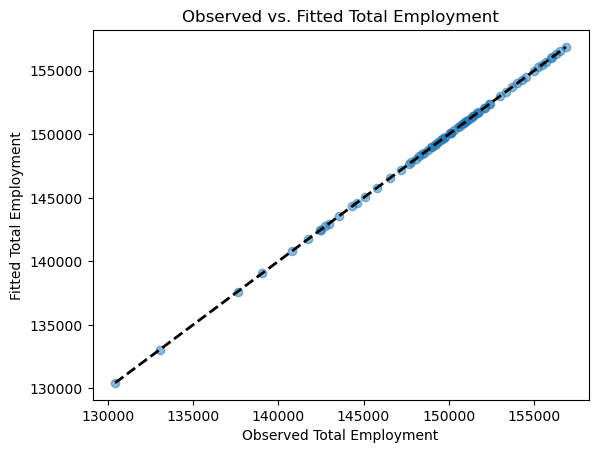

In [106]:
# Plot the fitted values against the observed values
fig, ax = plt.subplots()
ax.scatter(y, results.fittedvalues, alpha=0.5)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Observed Total Employment')
ax.set_ylabel('Fitted Total Employment')
ax.set_title('Observed vs. Fitted Total Employment')

# Show the plot
plt.show()

In [81]:
minus = emp.columns.drop(['Education', 'Manufacturing', 'Retail'])
Xma = MS(minus).fit_transform(emp)
model1 = sm.OLS(y, Xma)
summarize(model1.fit())

,coef,std err,t,P>|t|
intercept,-4.105000e-10,7.690000e-08,-5.000000e-03,0.996
Federal,2.500000e-01,1.040000e-11,2.400000e+10,0.000
Private,2.500000e-01,4.110000e-12,6.080000e+10,0.000
State & Local,2.500000e-01,3.270000e-12,7.640000e+10,0.000
Total Employment,7.500000e-01,4.030000e-12,1.860000e+11,0.000


In [82]:
#Gives us the R^2 and RSE
results.rsquared, np.sqrt(results.scale)

(1.0, 3.902966796937322e-09)

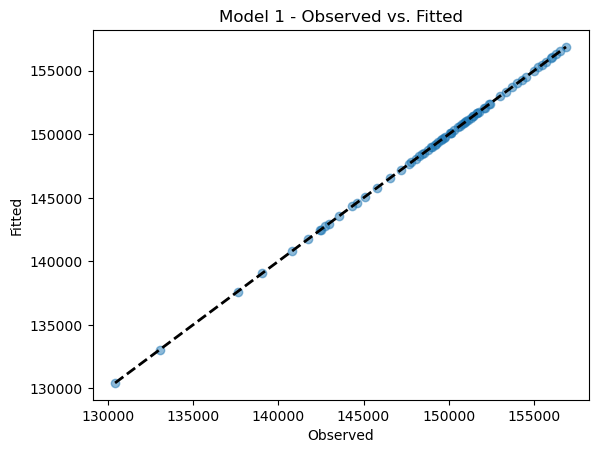

In [101]:
results1 = model1.fit()

fig, ax = plt.subplots()
ax.scatter(y, results1.fittedvalues, alpha=0.5)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Observed')
ax.set_ylabel('Fitted')
ax.set_title('Model 1 - Observed vs. Fitted')

plt.show()

In [83]:
vals = [VIF(X, i)
        for i in range(1, X.shape[1])]
vif = pd.DataFrame({'vif':vals},
                   index=X.columns[1:])
vif

,vif
Federal,1.834030
Manufacturing,39.328983
Private,28.967163
Retail,3.304919
Education,1.261740
State & Local,3.960224


In [91]:
correlation_matrix  = emp.corr()
correlation_matrix 

,Federal,Manufacturing,Private,Retail,Education,State & Local,Total Employment
Federal,1.000000,-0.316589,-0.175598,-0.372762,-0.339933,-0.452365,-0.187703
Manufacturing,-0.316589,1.000000,0.969817,0.825193,0.293275,0.805559,0.975330
Private,-0.175598,0.969817,1.000000,0.794269,0.252655,0.713106,0.998904
Retail,-0.372762,0.825193,0.794269,1.000000,0.268310,0.678472,0.798794
Education,-0.339933,0.293275,0.252655,0.268310,1.000000,0.405743,0.265320
State & Local,-0.452365,0.805559,0.713106,0.678472,0.405743,1.000000,0.744317
Total Employment,-0.187703,0.975330,0.998904,0.798794,0.265320,0.744317,1.000000


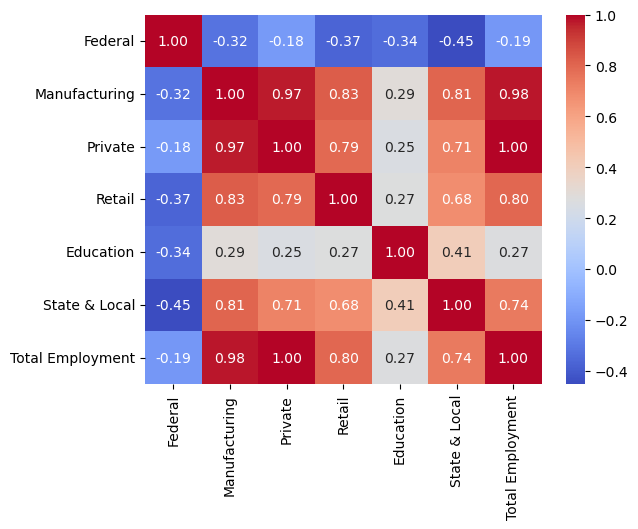

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

plt.show()

In [109]:
X2 = MS(['Federal', 
         ('Manufacturing','Private', 'Retail'),
         'Education', 
         'State & Local']).fit_transform(emp)
model2 = sm.OLS(y, X2)
summarize(model2.fit())

,coef,std err,t,P>|t|
intercept,2.300000e-03,0.000000e+00,13.276,0.000
Federal,1.668380e+01,1.373000e+00,12.148,0.000
Manufacturing:Private:Retail,2.342000e-09,7.980000e-11,29.350,0.000
Education,1.399000e-01,1.980000e-01,0.707,0.482
State & Local,2.161700e+00,3.060000e-01,7.073,0.000


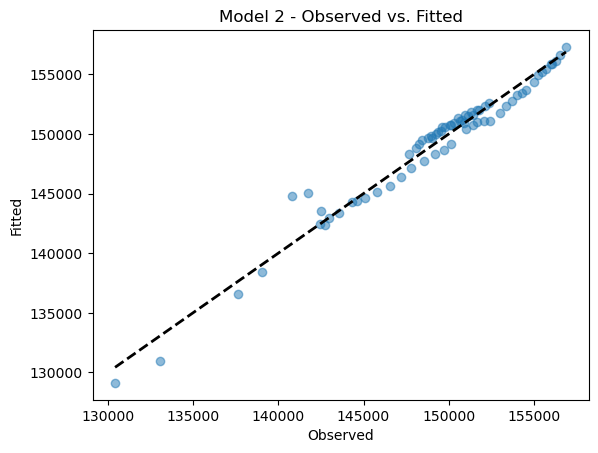

In [110]:
results2 = model2.fit()

fig, ax = plt.subplots()
ax.scatter(y, results2.fittedvalues, alpha=0.5)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Observed')
ax.set_ylabel('Fitted')
ax.set_title('Model 2 - Observed vs. Fitted')

plt.show()

In [102]:
results2.rsquared, np.sqrt(results2.scale)

(0.9666924211603719, 987.1826822747998)

In [144]:
# Cp Statistic
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)

In [138]:
from functools import partial
from statsmodels.api import OLS

def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n

In [141]:
design = MS(emp.columns.drop('Total Employment')).fit(emp)
Y = np.array(emp['Total Employment'])
X = design.transform(emp)
sigma2 = OLS(Y,X).fit().scale

neg_Cp = partial(nCp, sigma2)

functools.partial(<function nCp at 0x287e3cd30>, 5.643835174842322e-19)

In [148]:
# Performing Forward Regression
strategy = Stepwise.first_peak(design,
                               direction='forward',
                               max_terms=len(design.terms))

emp_MSE = sklearn_selected(OLS,
                               strategy)
emp_MSE.fit(emp, Y)
emp_MSE.selected_state_

('Federal', 'Private', 'State & Local')

In [149]:
# Choosing Predictors Based on Cp Statistic
emp_Cp = sklearn_selected(OLS,
                               strategy,
                               scoring=neg_Cp)
emp_Cp.fit(emp, Y)
emp_Cp.selected_state_

('Federal', 'Private', 'Retail', 'State & Local')

In [151]:
strategy = Stepwise.fixed_steps(design,
                                len(design.terms),
                                direction='forward')
full_path = sklearn_selection_path(OLS, strategy)

full_path.fit(emp, Y)
Yhat_in = full_path.predict(emp)
Yhat_in.shape
# Gives an array of fitted values
# 7 steps in all which we can use to evaluate in-sample MSE 

(69, 7)

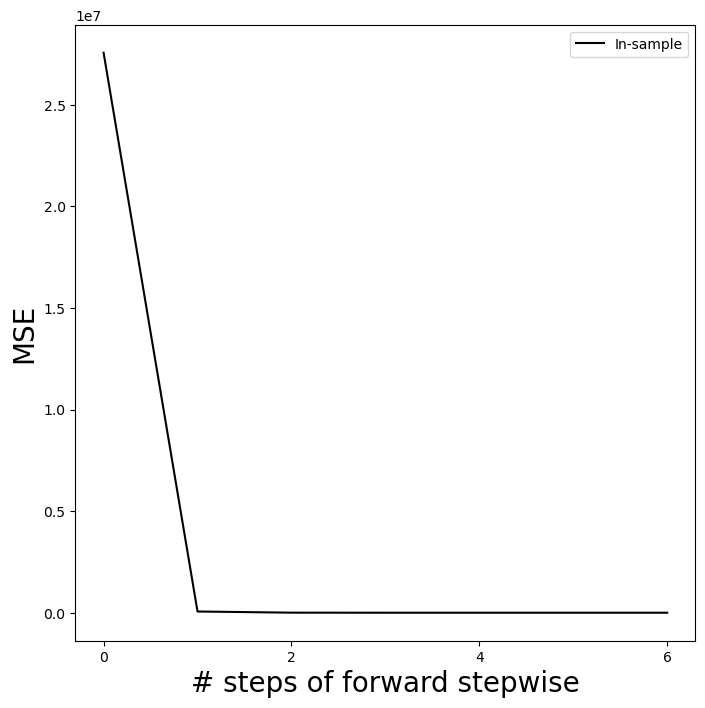

In [157]:
mse_fig, ax = subplots(figsize=(8,8))
insample_mse = ((Yhat_in - Y[:,None])**2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps),
        insample_mse,
        'k', # color black
        label='In-sample')
ax.set_ylabel('MSE',
              fontsize=20)
ax.set_xlabel('# steps of forward stepwise',
              fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend();

In [158]:
K = 5
kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)
Yhat_cv = skm.cross_val_predict(full_path,
                                emp,
                                Y,
                                cv=kfold)
Yhat_cv.shape
#The prediction matrix is the same as the previous one
#Must know the test indicies for each cross-validation split

(69, 7)

In [159]:
cv_mse = []
for train_idx, test_idx in kfold.split(Y):
    errors = (Yhat_cv[test_idx] - Y[test_idx,None])**2
    cv_mse.append(errors.mean(0)) # column means
cv_mse = np.array(cv_mse).T
cv_mse.shape

(7, 5)

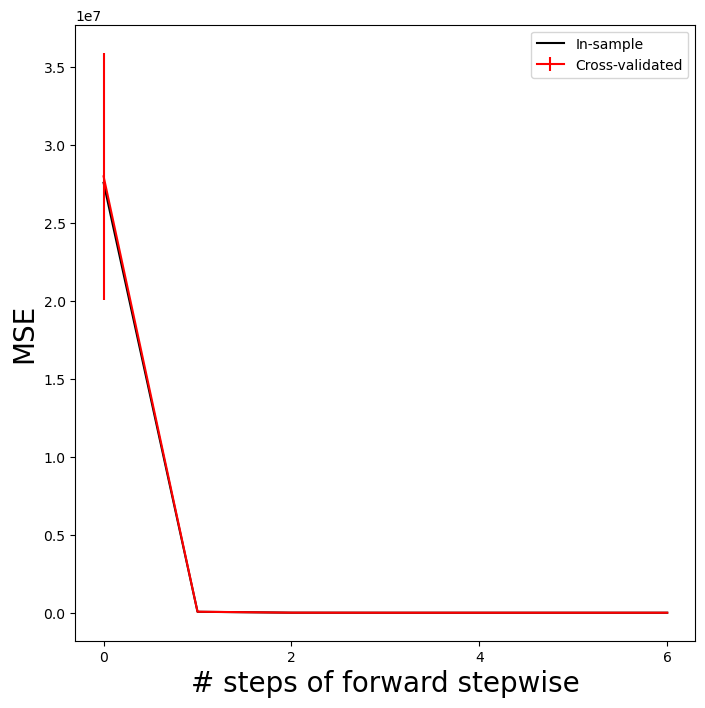

In [160]:
ax.errorbar(np.arange(n_steps),
            cv_mse.mean(1),
            cv_mse.std(1) / np.sqrt(K),
            label='Cross-validated',
            c='r') # color red
ax.legend()
mse_fig

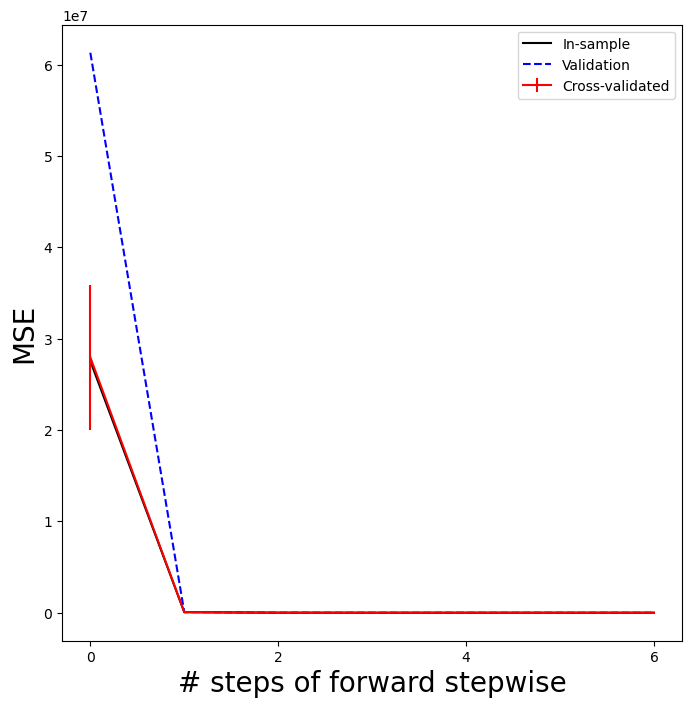

In [162]:
validation = skm.ShuffleSplit(n_splits=1,
                              test_size=0.2,
                              random_state=0)
for train_idx, test_idx in validation.split(Y):
    full_path.fit(emp.iloc[train_idx],
                  Y[train_idx])
    Yhat_val = full_path.predict(emp.iloc[test_idx])
    errors = (Yhat_val - Y[test_idx,None])**2
    validation_mse = errors.mean(0)
    
ax.plot(np.arange(n_steps),
        validation_mse,
        'b--', # color blue, broken line
        label='Validation')
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
mse_fig

In [165]:
# Best Subset Selection
D = design.fit_transform(emp)
D = D.drop('intercept', axis=1)
X = np.asarray(D)